### Phase 5: Feature Compaction (Autoencoder)
	10.	Construct per-image attribute vectors
	•	For each image:
	•	Multiply attribute embeddings by +1/-1 based on the attribute label.
	•	Concatenate into a single vector (shape: 40 × d).
	11.	Design an autoencoder
	•	Encoder: Compress 40×d input into a latent_dim vector (e.g., 128-dim).
	•	Decoder: Reconstruct the original 40×d vector.
	12.	Train the autoencoder
	•	Minimize reconstruction error (MSE loss).
	•	Save the trained autoencoder model.
	13.	Compress attribute vectors
	•	Pass the per-image attribute vectors through the autoencoder encoder to obtain compressed 128-dim vectors.



In [ ]:
### Note after around 50/60 iterations

In [ ]:
import os
from pathlib import Path

out_dir = Path("transE_celeba_3")
print("Top‐level contents:", os.listdir(out_dir))

tt_dir = out_dir / "training_triples"
print("Contents of training_triples/:", os.listdir(tt_dir))

Top‐level contents: ['training_triples', 'results.json', 'metadata.json', 'trained_model.pkl']
Contents of training_triples/: ['entity_to_id.tsv.gz', 'relation_to_id.tsv.gz', 'numeric_triples.tsv.gz', 'base.pth']


In [ ]:
# ─── A) Define paths ──────────────────────────────────────────────────────────
out_dir    = Path("transE_celeba_3")
tt_dir     = out_dir / "training_triples"
model_path = out_dir / "trained_model.pkl"
ent_map_fp = tt_dir  / "entity_to_id.tsv.gz"
rel_map_fp = tt_dir  / "relation_to_id.tsv.gz"
triples_fp = tt_dir  / "numeric_triples.tsv.gz"

In [ ]:
# ─── B) Load your trained TransE model ───────────────────────────────────────
model = torch.load(model_path, map_location="cpu", weights_only=False)
model.eval()
num_entities  = model.num_entities
num_relations = model.num_relations

print("Model expects:")
print(f"  • num_entities  = {num_entities}")
print(f"  • num_relations = {num_relations}")

Model expects:
  • num_entities  = 202639
  • num_relations = 12


In [ ]:
print("Model.num_entities  =", model.num_entities)
print("TF.num_entities     =", tf_num.num_entities)
print("Model.num_relations =", model.num_relations)
print("TF.num_relations    =", tf_num.num_relations)

Model.num_entities  = 202639
TF.num_entities     = 202639
Model.num_relations = 12
TF.num_relations    = 12


In [ ]:
print(type(model))
print(model)

<class 'pykeen.models.unimodal.trans_e.TransE'>
TransE(
  (loss): MarginRankingLoss(
    (margin_activation): ReLU()
  )
  (interaction): TransEInteraction()
  (entity_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(202639, 50)
    )
  )
  (relation_representations): ModuleList(
    (0): Embedding(
      (_embeddings): Embedding(12, 50)
    )
  )
  (weight_regularizers): ModuleList()
)


In [ ]:
## Load instance of the model
model = TransE(num_entities=len(entity_to_id), num_relations=len(relation_to_id), embedding_dim=50)

In [ ]:
import torch
import numpy as np

# 1) Grab the representation module
rep = result.model.entity_representations[0]

# 2) Make a tensor of all entity IDs
num_entities = tf.num_entities
all_ids = torch.arange(num_entities, dtype=torch.long)

# 3) Call the module to get all embeddings at once
#    Shape will be [num_entities, embedding_dim]
with torch.no_grad():
    weights = rep(all_ids).cpu().numpy()


print("weights.shape:", weights.shape)  # e.g. (202639, 50)

# 4) Build  40×50 attribute‐only matrix
ent2id     = tf.entity_to_id
attr_names = list(df_attrs.columns)    # your 40 attribute names
attr_embeddings = np.vstack([weights[ent2id[a]] for a in attr_names])
print("attr_embeddings.shape:", attr_embeddings.shape)  # (40, 50)


weights.shape: (202639, 50)
attr_embeddings.shape: (40, 50)


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# attr_embeddings: NumPy array shape (40, 50)
attr_emb_t = torch.from_numpy(attr_embeddings)       # [40, 50]

# Build a list of per–image vectors
vectors = []
for img_name, row in df_attrs.iterrows():
    # row is series of 0/1 labels for the 40 attrs
    labels = torch.tensor(row.values, dtype=torch.float32)  # [40]
    # multiply each attr embedding by its label and flatten
    vec = (labels.unsqueeze(1) * attr_emb_t).view(-1)       # [40*50]
    vectors.append(vec)

# Stack into one big tensor [N_images, 2000]
X = torch.stack(vectors)
print("Per‐image matrix X:", X.shape)
# Wrap as a DataLoader for training
dataset_ae = TensorDataset(X, X)
loader = DataLoader(dataset_ae, batch_size=256, shuffle=True)


Per‐image matrix X: torch.Size([202599, 2000])


In [ ]:
# ---- 2) Choose how many random features to add ----
random_dim = 128
N = X.shape[0]

# ---- 3) Draw random noise ----
# using a fixed seed for reproducibility
rng = np.random.default_rng(seed=42)
R = torch.from_numpy(rng.standard_normal((N, random_dim)).astype(np.float32))

# ---- 4) Concatenate semantic + random ----
X_aug = torch.cat([X, R], dim=1)   # shape = [N, 2000 + 128]
print("Augmented X shape:", X_aug.shape)  # → ([N, 2128])

Augmented X shape: torch.Size([202599, 2128])


In [ ]:
# ---- 5) Wrap into Dataset/Loader ----
dataset_ae = TensorDataset(X_aug, X_aug)  # target = input
train_size = int(0.8 * N)
val_size   = N - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset_ae, [train_size, val_size], generator=torch.Generator().manual_seed(42))

batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)


## Build autoencoder

In [ ]:
import torch.nn as nn

class AttrAutoencoder(nn.Module):
    def __init__(self, input_dim=2000, latent_dim=128):
        super().__init__()
        # encoder: 2000 → 512 → 128
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, latent_dim),
        )
        # decoder: 128 → 512 → 2000
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, input_dim),
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z



In [ ]:
# 2) Decide split sizes
from torch.utils.data import random_split, DataLoader, TensorDataset

print(f"Train samples: {len(train_ds)}, Val samples: {len(val_ds)}")

# Instantiate the Autoencoder model
autoenc = AttrAutoencoder(input_dim=X_aug.shape[1], latent_dim=128)
print("Autoencoder instantiated.")

Train samples: 162079, Val samples: 40520
Autoencoder instantiated.


## Train Autoencoder

In [ ]:
# --- Step 7: Train the Autoencoder with checkpointing and LR scheduling ---
import torch.nn as nn, torch.optim as optim
device = "cuda" if torch.cuda.is_available() else "cpu"
autoenc.to(device)
optimizer = optim.Adam(autoenc.parameters(), lr=1e-3)
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

best_val = float('inf')
num_epochs = 50

for epoch in range(1, num_epochs + 1):
    # Train
    autoenc.train()
    train_loss = 0.0
    for xb, _ in train_loader:
        xb = xb.to(device)
        optimizer.zero_grad()
        x_hat, _ = autoenc(xb)
        loss = criterion(x_hat, xb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= train_size

    # Validate
    autoenc.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, _ in val_loader:
            xb = xb.to(device)
            x_hat, _ = autoenc(xb)
            val_loss += criterion(x_hat, xb).item() * xb.size(0)
    val_loss /= val_size

    # Scheduler & checkpoint
    scheduler.step(val_loss)
    if val_loss < best_val:
        best_val = val_loss
        torch.save(autoenc.state_dict(), "best_autoenc.pt")

    print(f"Epoch {epoch:2d} | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f}")

Epoch  1 | Train MSE: 0.009592 | Val MSE: 0.008668
Epoch  2 | Train MSE: 0.008075 | Val MSE: 0.008429
Epoch  3 | Train MSE: 0.008084 | Val MSE: 0.008453
Epoch  4 | Train MSE: 0.008084 | Val MSE: 0.008382
Epoch  5 | Train MSE: 0.007883 | Val MSE: 0.008246
Epoch  6 | Train MSE: 0.007741 | Val MSE: 0.007975
Epoch  7 | Train MSE: 0.007677 | Val MSE: 0.007967
Epoch  8 | Train MSE: 0.007655 | Val MSE: 0.008034
Epoch  9 | Train MSE: 0.007644 | Val MSE: 0.008123
Epoch 10 | Train MSE: 0.007631 | Val MSE: 0.008037
Epoch 11 | Train MSE: 0.007610 | Val MSE: 0.008376
Epoch 12 | Train MSE: 0.007229 | Val MSE: 0.007436
Epoch 13 | Train MSE: 0.007181 | Val MSE: 0.007332
Epoch 14 | Train MSE: 0.007054 | Val MSE: 0.007158
Epoch 15 | Train MSE: 0.006904 | Val MSE: 0.007117
Epoch 16 | Train MSE: 0.006851 | Val MSE: 0.007181
Epoch 17 | Train MSE: 0.006812 | Val MSE: 0.006982
Epoch 18 | Train MSE: 0.006770 | Val MSE: 0.006959
Epoch 19 | Train MSE: 0.006730 | Val MSE: 0.007004
Epoch 20 | Train MSE: 0.006704 

### Latent space visualization

In [ ]:
!pip install umap-learn

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


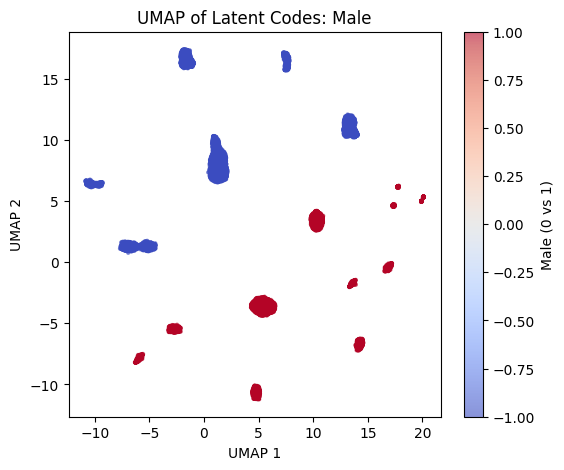

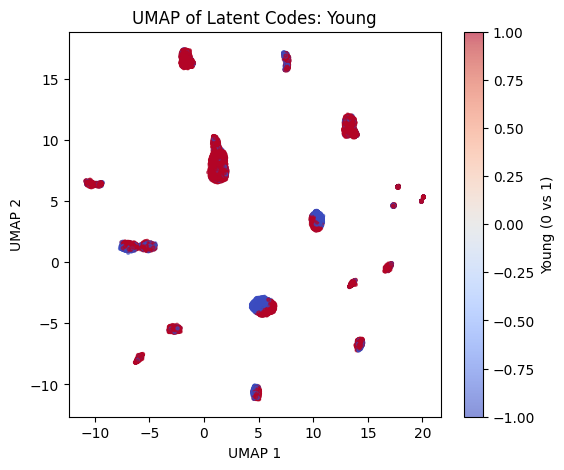

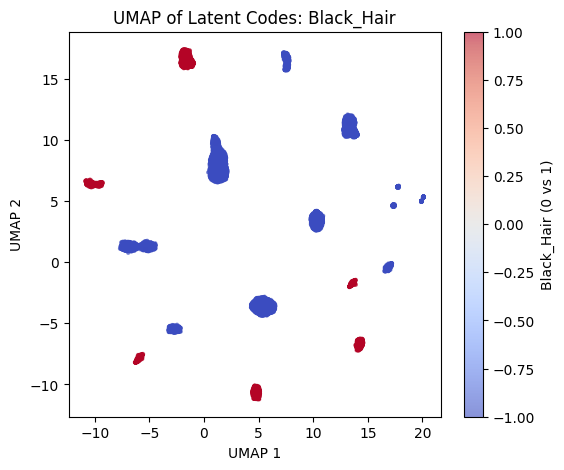

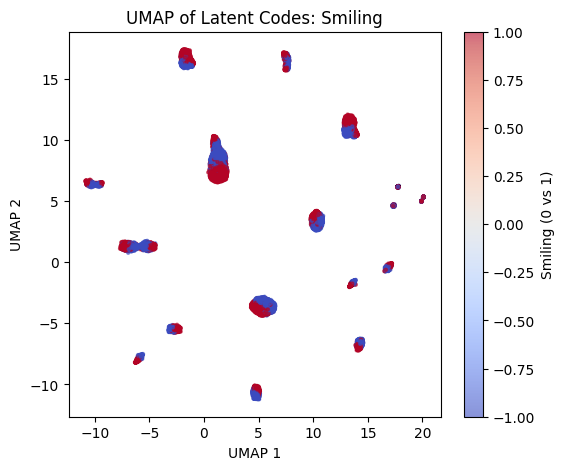

KeyError: 'Wearing_Glasses'

In [ ]:
import umap
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset


# Assume X_aug is your [N, input_dim] tensor
full_ds    = TensorDataset(X_aug, X_aug)
full_loader = DataLoader(full_ds, batch_size=256, shuffle=False)

autoenc.eval()
Z_list = []
with torch.no_grad():
    for xb, _ in full_loader:
        xb = xb.to(device)
        _, z = autoenc(xb)
        Z_list.append(z.cpu().numpy())
Z = np.vstack(Z_list)     # shape: (N_images, latent_dim)


reducer = umap.UMAP(
    n_components=2,
    n_neighbors=30,     # controls local-vs-global tradeoff
    min_dist=0.1,       # how tightly packed clusters are
    random_state=42,
)
Z_umap = reducer.fit_transform(Z)  # → (N_images, 2)


In [ ]:
def plot_umap(attr_name):
    labels = df_attrs[attr_name].values  # 0/1 or 1/–1; convert if needed
    # If your df_attrs is 1/–1:
    # labels = (df_attrs[attr_name].values == 1).astype(int)

    plt.figure(figsize=(6, 5))
    plt.scatter(
        Z_umap[:, 0], Z_umap[:, 1],
        c=labels,
        cmap='coolwarm',
        alpha=0.6,
        s=5
    )
    plt.title(f"UMAP of Latent Codes: {attr_name}")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.colorbar(label=f"{attr_name} (0 vs 1)")
    plt.savefig(f"umap_{attr_name}.png")
    plt.show()

Available attrs: ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


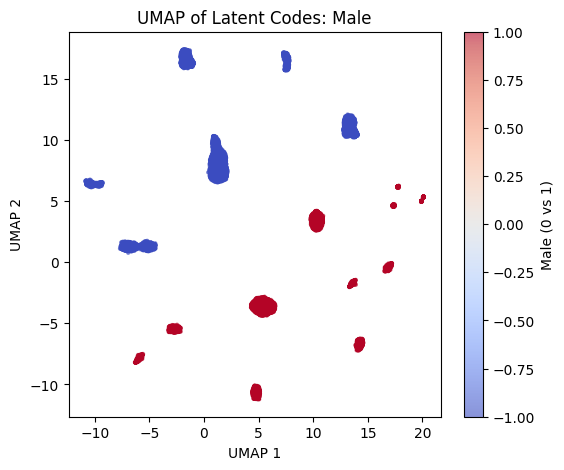

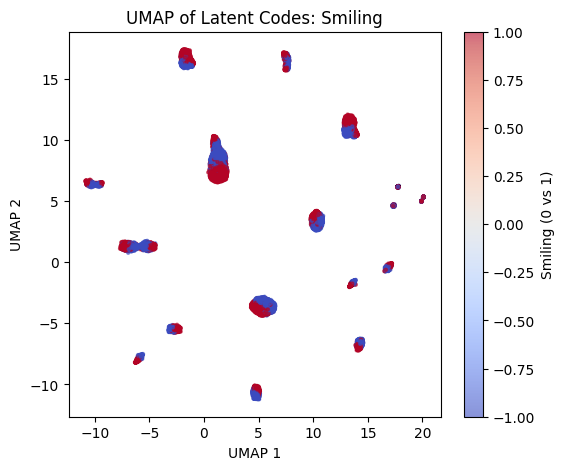

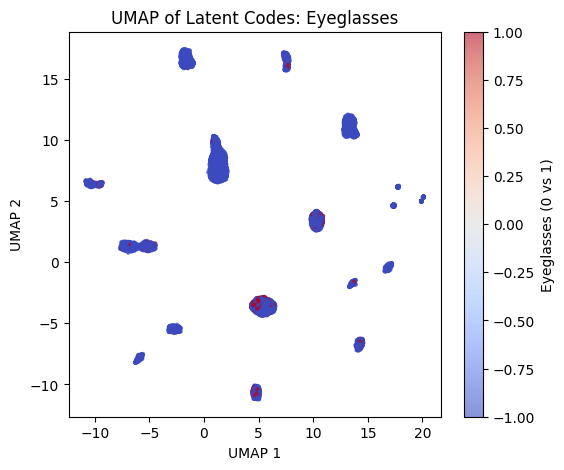

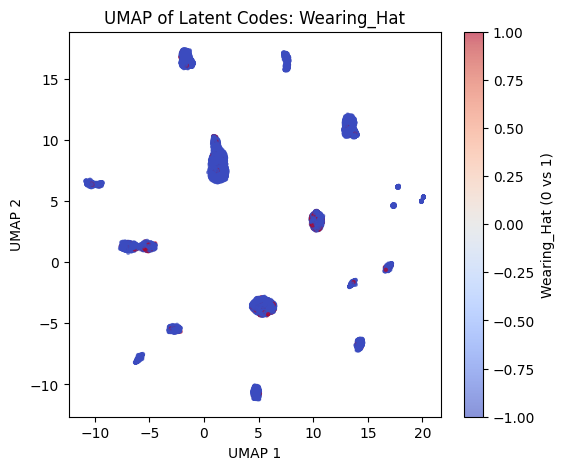

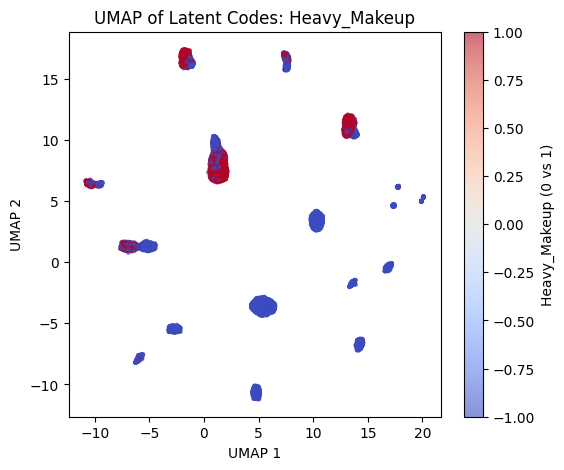

In [ ]:
print("Available attrs:", df_attrs.columns.tolist())

# Now plot a few with correct names:
plot_umap("Male")
plot_umap("Smiling")
plot_umap("Eyeglasses")    # not "Wearing_Glasses"
plot_umap("Wearing_Hat")
plot_umap("Heavy_Makeup")

In [ ]:
from sklearn.metrics import silhouette_score
print("Gender silhouette:", silhouette_score(Z, (df_attrs['Male']==1).astype(int)))

Gender silhouette: 0.26595205


## Extrace compressed vectors

-- 128-dim representation for each CelebA image, ready to be projected into the Stable Diffusion conditioning space

In [ ]:
torch.save(autoenc.state_dict(), "attr_autoencoder.pth")

In [ ]:
autoenc.eval()
all_z = []
with torch.no_grad():
    for xb, _ in loader:
        xb = xb.to(device)
        _, z = autoenc(xb)
        all_z.append(z.cpu())
all_z = torch.cat(all_z, dim=0)  # [N_images, 128]
print("Compressed features:", all_z.shape)
# Optionally save
import numpy as np
np.save("compressed_attr_vectors.npy", all_z.numpy())


Compressed features: torch.Size([202599, 128])


In [ ]:
class AttrAutoencoder(nn.Module):
    def _init_(self, input_dim=2128, latent_dim=128):
        super()._init_()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z), z

autoenc = AttrAutoencoder(input_dim=2128, latent_dim=128).to(device)
autoenc.load_state_dict(torch.load('best_autoenc.pt', map_location=device))
autoenc.eval()
print("✅ Autoencoder loaded.")